In [0]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Vision System Project CA1 and CA2B/CA1-SSD/')
!ls
!pip install imgaug

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Codes			      'Pixel Representation for SSD.gsheet'
 data			       predefined_classes.txt
'Final Report.docx'	       pretrain_ssd224.h5
'Final Report _ donal.docx'    __pycache__
 keras_ssd_pretrained_224.py  'Reading Materials.gdoc'
 MobileNets.pdf		       Report
 MobileNetv2.pdf	       Supermarket_Dataset_Vidur
 old_weights		       train_ssd.ipynb


In [0]:
import numpy as np
from array import array
import cv2
from math import ceil
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
import glob

from keras_ssd_pretrained_224 import build_model
from keras_ssd_pretrained_224 import SSDLoss
from keras_ssd_pretrained_224 import data_generator
from keras_ssd_pretrained_224 import SSDInputEncoder
from keras_ssd_pretrained_224 import decode_detections
from keras_ssd_pretrained_224 import xml_to_csv
from keras_ssd_pretrained_224 import read_csv
from keras_ssd_pretrained_224 import image_augmentation

# 1. Building Model

In [0]:
# Load pre-trained weights
loadweights = False
weightsfile = "pretrain_ssd224.h5"

# Model Parameters
aspect_ratio = [1, 2, 3, 0.5, 0.33]
n_classes = 2
img_height = 224
img_width = 224
img_channels = 3
min_scale = 0.1
max_scale = 0.9


In [0]:
# Build Model
model = build_model((img_height,img_width,img_channels),
                n_classes,
                l2_reg=0.0,
                min_scale=min_scale,
                max_scale=max_scale,
                aspect_ratios=aspect_ratio)

if loadweights:
    model.load_weights(weightsfile)
    print("weights Loaded")


adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model = build_model((img_height,img_width,img_channels),
                n_classes,
                l2_reg=0.0,
                min_scale=min_scale,
                max_scale=max_scale,
                aspect_ratios=aspect_ratio)
model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
model.summary()


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
_______________________________________________________________________________________________

# 2. Data Generator
 In this section we create two data generators, one each for training and validation.
 The data generator function(*data_generator*) accepts image and xml directory, along with some image augmentation parameters. 

In [0]:
data_dir = 'data/'
train_image_dir = data_dir+'img_train/'
val_image_dir = data_dir+'img_val/'
batch_size = 2

# Featue Map shape of each predictor layer
predictor_sizes = [model.get_layer('classes1').output_shape[1:3],
                   model.get_layer('classes2').output_shape[1:3],
                   model.get_layer('classes3').output_shape[1:3],
                   model.get_layer('classes4').output_shape[1:3],
                   model.get_layer('classes5').output_shape[1:3],
                   model.get_layer('classes6').output_shape[1:3]]


# Ground Truth Label encoder
label_encoder = SSDInputEncoder(img_height,
                                img_width,
                                n_classes,
                                predictor_sizes,
                                min_scale=min_scale,
                                max_scale=max_scale,
                                aspect_ratios=aspect_ratio,
                                pos_iou_threshold=0.5,
                                neg_iou_limit=0.3,
                                background_id=0)
train_dataset, n_train_imgs = data_generator(img_dir = train_image_dir, xml_dir = train_image_dir, batch_size=batch_size, steps_per_epoch=None, img_sz=224, label_encoder=label_encoder,
                                                   translate=0, rotate=0, scale=1, shear=0, hor_flip=True, ver_flip=False, applyfilter=True)

val_dataset, n_val_imgs = data_generator(img_dir = val_image_dir, xml_dir = val_image_dir, batch_size=batch_size, steps_per_epoch=None, img_sz=224, label_encoder=label_encoder,
                       translate=0, rotate=0, scale=1, shear=0, hor_flip=False, ver_flip=False, applyfilter=False)

print("train images : ", n_train_imgs)
print("validation images : ", n_val_imgs)

Successfully created labels.csv file at xml directory.
Successfully created labels.csv file at xml directory.
train images :  293
validation images :  32


# 3 Learning Rate Schedule

In [0]:
# Define a learning rate schedule.
def lr_schedule(epoch):
    if epoch < 10:
        return 0.001
    elif epoch < 20:
        return 0.0009
    elif epoch < 30:
        return 0.0008
    elif epoch < 40:
        return 0.0007
    elif epoch < 50:
        return 0.0006
    elif epoch < 100:
        return 0.0005
    elif epoch < 200:
        return 0.0004
    elif epoch < 300:
        return 0.0003
    elif epoch < 400:
        return 0.0002
    elif epoch < 500:
        return 0.0001
    else:
        return 0.00005

      
      
learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule,
                                                verbose=1)

# 4 Model Checkpoints

In [0]:

# TODO: Set the filepath under which you want to save the model.
model_checkpoint = ModelCheckpoint(filepath='pretrain_ssd224.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)


csv_logger = CSVLogger(filename='pretrain_ssd224+12_training_log.csv',
                       separator=',',
                       append=True)


callbacks = [model_checkpoint,
             csv_logger,
             learning_rate_scheduler]







# 5 Fit Generator

In [0]:
# If you're resuming a previous training, set `initial_epoch` and `final_epoch` accordingly.
initial_epoch = 0
final_epoch = 1000
train_steps_per_epoch = ceil(n_train_imgs/batch_size)
val_steps_per_epoch = ceil(n_val_imgs/batch_size)
val_dataset_size = 10

history = model.fit_generator(generator=train_dataset,
                              validation_data=val_dataset,
                              validation_steps=val_steps_per_epoch,
                              steps_per_epoch=train_steps_per_epoch,
                              callbacks = callbacks,
                              epochs=final_epoch)

C:\Users\Donal\.conda\envs\rtavs\lib\site-packages\imgaug\imgaug.py:182: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)



Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/1000


C:\Users\Donal\.conda\envs\rtavs\lib\site-packages\imgaug\imgaug.py:182: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


146/147 [============================>.] - ETA: 0s - loss: 92.3578
Epoch 00001: val_loss improved from inf to 48.90769, saving model to pretrain_ssd224.h5
147/147 [==============================] - 179s 1s/step - loss: 92.0968 - val_loss: 48.9077

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/1000
146/147 [============================>.] - ETA: 0s - loss: 42.8489
Epoch 00002: val_loss improved from 48.90769 to 22.44810, saving model to pretrain_ssd224.h5
147/147 [==============================] - 142s 966ms/step - loss: 42.7075 - val_loss: 22.4481

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/1000
146/147 [============================>.] - ETA: 0s - loss: 22.5337
Epoch 00003: val_loss improved from 22.44810 to 10.25639, saving model to pretrain_ssd224.h5
147/147 [==============================] - 142s 968ms/step - loss: 22.4419 - val_loss: 10.2564

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.
Epoch 4/10


Epoch 00027: LearningRateScheduler reducing learning rate to 0.0008.
Epoch 27/1000
146/147 [============================>.] - ETA: 0s - loss: 1.1942
Epoch 00027: val_loss did not improve from 1.36061
147/147 [==============================] - 146s 995ms/step - loss: 1.1908 - val_loss: 1.3634

Epoch 00028: LearningRateScheduler reducing learning rate to 0.0008.
Epoch 28/1000
146/147 [============================>.] - ETA: 0s - loss: 1.0923
Epoch 00028: val_loss did not improve from 1.36061
147/147 [==============================] - 146s 995ms/step - loss: 1.0901 - val_loss: 1.4351

Epoch 00029: LearningRateScheduler reducing learning rate to 0.0008.
Epoch 29/1000
146/147 [============================>.] - ETA: 0s - loss: 0.9617
Epoch 00029: val_loss improved from 1.36061 to 1.33509, saving model to pretrain_ssd224.h5
147/147 [==============================] - 147s 1000ms/step - loss: 0.9588 - val_loss: 1.3351

Epoch 00030: LearningRateScheduler reducing learning rate to 0.0008.
Epoch 3


Epoch 00054: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 54/1000
146/147 [============================>.] - ETA: 0s - loss: 0.3812
Epoch 00054: val_loss did not improve from 0.69690
147/147 [==============================] - 55s 375ms/step - loss: 0.3801 - val_loss: 0.8162

Epoch 00055: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 55/1000
146/147 [============================>.] - ETA: 0s - loss: 0.3897
Epoch 00055: val_loss did not improve from 0.69690
147/147 [==============================] - 55s 375ms/step - loss: 0.3883 - val_loss: 0.7275

Epoch 00056: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 56/1000
146/147 [============================>.] - ETA: 0s - loss: 0.2975
Epoch 00056: val_loss did not improve from 0.69690
147/147 [==============================] - 55s 374ms/step - loss: 0.2966 - val_loss: 0.7322

Epoch 00057: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 57/1000
146/147 [============================


Epoch 00082: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 82/1000
146/147 [============================>.] - ETA: 0s - loss: 0.1948
Epoch 00082: val_loss did not improve from 0.64325
147/147 [==============================] - 55s 378ms/step - loss: 0.1941 - val_loss: 0.7047

Epoch 00083: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 83/1000
146/147 [============================>.] - ETA: 0s - loss: 0.1871
Epoch 00083: val_loss improved from 0.64325 to 0.61571, saving model to pretrain_ssd224.h5
147/147 [==============================] - 55s 377ms/step - loss: 0.1863 - val_loss: 0.6157

Epoch 00084: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 84/1000
146/147 [============================>.] - ETA: 0s - loss: 0.1583
Epoch 00084: val_loss did not improve from 0.61571
147/147 [==============================] - 55s 377ms/step - loss: 0.1577 - val_loss: 0.7112

Epoch 00085: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 85/10

146/147 [============================>.] - ETA: 0s - loss: 0.0792
Epoch 00109: val_loss did not improve from 0.48327
147/147 [==============================] - 55s 377ms/step - loss: 0.0788 - val_loss: 0.5607

Epoch 00110: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 110/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0863
Epoch 00110: val_loss did not improve from 0.48327
147/147 [==============================] - 55s 377ms/step - loss: 0.0859 - val_loss: 0.6002

Epoch 00111: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 111/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0874
Epoch 00111: val_loss did not improve from 0.48327
147/147 [==============================] - 55s 376ms/step - loss: 0.0871 - val_loss: 0.6030

Epoch 00112: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 112/1000
146/147 [============================>.] - ETA: 0s - loss: 0.1868
Epoch 00112: val_loss did not improve from 0.48327
1

146/147 [============================>.] - ETA: 0s - loss: 0.0692
Epoch 00137: val_loss did not improve from 0.48327
147/147 [==============================] - 56s 378ms/step - loss: 0.0688 - val_loss: 0.6905

Epoch 00138: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 138/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0806
Epoch 00138: val_loss did not improve from 0.48327
147/147 [==============================] - 56s 381ms/step - loss: 0.0802 - val_loss: 0.6299

Epoch 00139: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 139/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0788
Epoch 00139: val_loss did not improve from 0.48327
147/147 [==============================] - 57s 388ms/step - loss: 0.0783 - val_loss: 0.6982

Epoch 00140: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 140/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0568
Epoch 00140: val_loss did not improve from 0.48327
1

146/147 [============================>.] - ETA: 0s - loss: 0.0446
Epoch 00165: val_loss did not improve from 0.48007
147/147 [==============================] - 56s 382ms/step - loss: 0.0443 - val_loss: 0.9619

Epoch 00166: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 166/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0402
Epoch 00166: val_loss did not improve from 0.48007
147/147 [==============================] - 57s 385ms/step - loss: 0.0401 - val_loss: 0.4852

Epoch 00167: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 167/1000
146/147 [============================>.] - ETA: 0s - loss: 0.1036
Epoch 00167: val_loss did not improve from 0.48007
147/147 [==============================] - 56s 382ms/step - loss: 0.1031 - val_loss: 0.5552

Epoch 00168: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 168/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0755
Epoch 00168: val_loss did not improve from 0.48007
1

146/147 [============================>.] - ETA: 0s - loss: 0.0445
Epoch 00193: val_loss did not improve from 0.48007
147/147 [==============================] - 57s 390ms/step - loss: 0.0443 - val_loss: 0.6487

Epoch 00194: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 194/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0548
Epoch 00194: val_loss did not improve from 0.48007
147/147 [==============================] - 59s 399ms/step - loss: 0.0545 - val_loss: 0.6520

Epoch 00195: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 195/1000
146/147 [============================>.] - ETA: 0s - loss: 0.1020
Epoch 00195: val_loss did not improve from 0.48007
147/147 [==============================] - 56s 383ms/step - loss: 0.1014 - val_loss: 1.3572

Epoch 00196: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 196/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0786
Epoch 00196: val_loss did not improve from 0.48007
1

146/147 [============================>.] - ETA: 0s - loss: 0.0245
Epoch 00221: val_loss did not improve from 0.48007
147/147 [==============================] - 57s 385ms/step - loss: 0.0243 - val_loss: 0.7155

Epoch 00222: LearningRateScheduler reducing learning rate to 0.0003.
Epoch 222/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0260
Epoch 00222: val_loss did not improve from 0.48007
147/147 [==============================] - 56s 383ms/step - loss: 0.0259 - val_loss: 0.6513

Epoch 00223: LearningRateScheduler reducing learning rate to 0.0003.
Epoch 223/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0258
Epoch 00223: val_loss did not improve from 0.48007
147/147 [==============================] - 56s 383ms/step - loss: 0.0257 - val_loss: 0.6425

Epoch 00224: LearningRateScheduler reducing learning rate to 0.0003.
Epoch 224/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0303
Epoch 00224: val_loss did not improve from 0.48007
1

146/147 [============================>.] - ETA: 0s - loss: 0.0377- ETA
Epoch 00249: val_loss did not improve from 0.48007
147/147 [==============================] - 56s 384ms/step - loss: 0.0375 - val_loss: 0.6031

Epoch 00250: LearningRateScheduler reducing learning rate to 0.0003.
Epoch 250/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0192
Epoch 00250: val_loss did not improve from 0.48007
147/147 [==============================] - 57s 385ms/step - loss: 0.0191 - val_loss: 0.6551

Epoch 00251: LearningRateScheduler reducing learning rate to 0.0003.
Epoch 251/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0250
Epoch 00251: val_loss did not improve from 0.48007
147/147 [==============================] - 56s 382ms/step - loss: 0.0250 - val_loss: 0.6585

Epoch 00252: LearningRateScheduler reducing learning rate to 0.0003.
Epoch 252/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0206- ETA
Epoch 00252: val_loss did not improve from

146/147 [============================>.] - ETA: 0s - loss: 0.0169
Epoch 00277: val_loss did not improve from 0.48007
147/147 [==============================] - 56s 382ms/step - loss: 0.0168 - val_loss: 0.5467

Epoch 00278: LearningRateScheduler reducing learning rate to 0.0003.
Epoch 278/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0570
Epoch 00278: val_loss did not improve from 0.48007
147/147 [==============================] - 56s 384ms/step - loss: 0.0567 - val_loss: 0.6782

Epoch 00279: LearningRateScheduler reducing learning rate to 0.0003.
Epoch 279/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00279: val_loss did not improve from 0.48007
147/147 [==============================] - 57s 387ms/step - loss: 0.0221 - val_loss: 0.6003

Epoch 00280: LearningRateScheduler reducing learning rate to 0.0003.
Epoch 280/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0246
Epoch 00280: val_loss did not improve from 0.48007
1

146/147 [============================>.] - ETA: 0s - loss: 0.0252
Epoch 00305: val_loss did not improve from 0.48007
147/147 [==============================] - 56s 382ms/step - loss: 0.0251 - val_loss: 0.6928

Epoch 00306: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 306/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0178- ETA
Epoch 00306: val_loss did not improve from 0.48007
147/147 [==============================] - 57s 385ms/step - loss: 0.0177 - val_loss: 0.6728

Epoch 00307: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 307/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0133
Epoch 00307: val_loss did not improve from 0.48007
147/147 [==============================] - 57s 385ms/step - loss: 0.0133 - val_loss: 0.6987

Epoch 00308: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 308/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0130
Epoch 00308: val_loss did not improve from 0.48

146/147 [============================>.] - ETA: 0s - loss: 0.0174
Epoch 00333: val_loss did not improve from 0.48007
147/147 [==============================] - 57s 391ms/step - loss: 0.0173 - val_loss: 0.7171

Epoch 00334: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 334/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0134
Epoch 00334: val_loss did not improve from 0.48007
147/147 [==============================] - 56s 383ms/step - loss: 0.0133 - val_loss: 0.7300

Epoch 00335: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 335/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0102
Epoch 00335: val_loss did not improve from 0.48007
147/147 [==============================] - 56s 383ms/step - loss: 0.0102 - val_loss: 0.7187

Epoch 00336: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 336/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0113
Epoch 00336: val_loss did not improve from 0.48007
1

146/147 [============================>.] - ETA: 0s - loss: 0.0138
Epoch 00361: val_loss did not improve from 0.48007
147/147 [==============================] - 56s 384ms/step - loss: 0.0137 - val_loss: 0.6801

Epoch 00362: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 362/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0246
Epoch 00362: val_loss did not improve from 0.48007
147/147 [==============================] - 57s 385ms/step - loss: 0.0245 - val_loss: 0.7196

Epoch 00363: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 363/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0118
Epoch 00363: val_loss did not improve from 0.48007
147/147 [==============================] - 59s 399ms/step - loss: 0.0117 - val_loss: 0.6949

Epoch 00364: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 364/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0088
Epoch 00364: val_loss did not improve from 0.48007
1


Epoch 00389: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 389/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0086
Epoch 00389: val_loss did not improve from 0.43871
147/147 [==============================] - 56s 383ms/step - loss: 0.0085 - val_loss: 0.5517

Epoch 00390: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 390/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0111
Epoch 00390: val_loss did not improve from 0.43871
147/147 [==============================] - 56s 381ms/step - loss: 0.0111 - val_loss: 0.5504

Epoch 00391: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 391/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0088
Epoch 00391: val_loss did not improve from 0.43871
147/147 [==============================] - 57s 384ms/step - loss: 0.0088 - val_loss: 0.5229

Epoch 00392: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 392/1000
146/147 [========================


Epoch 00417: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 417/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0086
Epoch 00417: val_loss did not improve from 0.43871
147/147 [==============================] - 56s 382ms/step - loss: 0.0086 - val_loss: 0.6200

Epoch 00418: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 418/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0085
Epoch 00418: val_loss did not improve from 0.43871
147/147 [==============================] - 57s 388ms/step - loss: 0.0084 - val_loss: 0.5968

Epoch 00419: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 419/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0068
Epoch 00419: val_loss did not improve from 0.43871
147/147 [==============================] - 57s 385ms/step - loss: 0.0067 - val_loss: 0.5809

Epoch 00420: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 420/1000
146/147 [========================


Epoch 00445: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 445/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0117
Epoch 00445: val_loss did not improve from 0.43871
147/147 [==============================] - 57s 390ms/step - loss: 0.0117 - val_loss: 0.5705

Epoch 00446: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 446/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0052
Epoch 00446: val_loss did not improve from 0.43871
147/147 [==============================] - 57s 386ms/step - loss: 0.0052 - val_loss: 0.5804

Epoch 00447: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 447/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0067
Epoch 00447: val_loss did not improve from 0.43871
147/147 [==============================] - 57s 386ms/step - loss: 0.0067 - val_loss: 0.5697

Epoch 00448: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 448/1000
146/147 [========================


Epoch 00473: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 473/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0047
Epoch 00473: val_loss did not improve from 0.43871
147/147 [==============================] - 56s 383ms/step - loss: 0.0047 - val_loss: 0.6189

Epoch 00474: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 474/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0049
Epoch 00474: val_loss did not improve from 0.43871
147/147 [==============================] - 57s 385ms/step - loss: 0.0049 - val_loss: 0.6361

Epoch 00475: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 475/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0046
Epoch 00475: val_loss did not improve from 0.43871
147/147 [==============================] - 57s 389ms/step - loss: 0.0046 - val_loss: 0.6075

Epoch 00476: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 476/1000
146/147 [========================


Epoch 00501: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 501/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0045
Epoch 00501: val_loss did not improve from 0.43871
147/147 [==============================] - 57s 384ms/step - loss: 0.0045 - val_loss: 0.6951

Epoch 00502: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 502/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0041
Epoch 00502: val_loss did not improve from 0.43871
147/147 [==============================] - 56s 383ms/step - loss: 0.0041 - val_loss: 0.7435

Epoch 00503: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 503/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0067
Epoch 00503: val_loss did not improve from 0.43871
147/147 [==============================] - 57s 388ms/step - loss: 0.0067 - val_loss: 0.7132

Epoch 00504: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 504/1000
146/147 [============================


Epoch 00529: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 529/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0043
Epoch 00529: val_loss did not improve from 0.43871
147/147 [==============================] - 56s 383ms/step - loss: 0.0043 - val_loss: 0.7024

Epoch 00530: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 530/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0033
Epoch 00530: val_loss did not improve from 0.43871
147/147 [==============================] - 56s 383ms/step - loss: 0.0033 - val_loss: 0.7217

Epoch 00531: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 531/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0046
Epoch 00531: val_loss did not improve from 0.43871
147/147 [==============================] - 57s 385ms/step - loss: 0.0046 - val_loss: 0.7259

Epoch 00532: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 532/1000
146/147 [============================


Epoch 00557: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 557/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0059
Epoch 00557: val_loss did not improve from 0.43871
147/147 [==============================] - 63s 429ms/step - loss: 0.0059 - val_loss: 0.7835

Epoch 00558: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 558/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0033
Epoch 00558: val_loss did not improve from 0.43871
147/147 [==============================] - 66s 449ms/step - loss: 0.0033 - val_loss: 0.7732

Epoch 00559: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 559/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0184
Epoch 00559: val_loss did not improve from 0.43871
147/147 [==============================] - 62s 425ms/step - loss: 0.0183 - val_loss: 0.7890

Epoch 00560: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 560/1000
146/147 [============================


Epoch 00585: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 585/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0027
Epoch 00585: val_loss did not improve from 0.43871
147/147 [==============================] - 61s 416ms/step - loss: 0.0027 - val_loss: 0.7335

Epoch 00586: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 586/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0051
Epoch 00586: val_loss did not improve from 0.43871
147/147 [==============================] - 63s 428ms/step - loss: 0.0051 - val_loss: 0.7312

Epoch 00587: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 587/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0027
Epoch 00587: val_loss did not improve from 0.43871
147/147 [==============================] - 58s 393ms/step - loss: 0.0027 - val_loss: 0.7195

Epoch 00588: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 588/1000
146/147 [============================


Epoch 00613: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 613/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0035
Epoch 00613: val_loss did not improve from 0.43871
147/147 [==============================] - 58s 397ms/step - loss: 0.0035 - val_loss: 0.7257

Epoch 00614: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 614/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0028
Epoch 00614: val_loss did not improve from 0.43871
147/147 [==============================] - 56s 383ms/step - loss: 0.0028 - val_loss: 0.7164

Epoch 00615: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 615/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0026
Epoch 00615: val_loss did not improve from 0.43871
147/147 [==============================] - 57s 387ms/step - loss: 0.0026 - val_loss: 0.6981

Epoch 00616: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 616/1000
146/147 [============================


Epoch 00641: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 641/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0250
Epoch 00641: val_loss did not improve from 0.43871
147/147 [==============================] - 58s 393ms/step - loss: 0.0249 - val_loss: 0.8130

Epoch 00642: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 642/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0029
Epoch 00642: val_loss did not improve from 0.43871
147/147 [==============================] - 58s 392ms/step - loss: 0.0029 - val_loss: 0.7871

Epoch 00643: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 643/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0034
Epoch 00643: val_loss did not improve from 0.43871
147/147 [==============================] - 57s 390ms/step - loss: 0.0034 - val_loss: 0.7688

Epoch 00644: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 644/1000
146/147 [============================


Epoch 00669: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 669/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0033
Epoch 00669: val_loss did not improve from 0.43871
147/147 [==============================] - 58s 393ms/step - loss: 0.0033 - val_loss: 0.7779

Epoch 00670: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 670/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0025
Epoch 00670: val_loss did not improve from 0.43871
147/147 [==============================] - 57s 388ms/step - loss: 0.0025 - val_loss: 0.7891

Epoch 00671: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 671/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0028
Epoch 00671: val_loss did not improve from 0.43871
147/147 [==============================] - 58s 393ms/step - loss: 0.0028 - val_loss: 0.7746

Epoch 00672: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 672/1000
146/147 [============================


Epoch 00697: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 697/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0024
Epoch 00697: val_loss did not improve from 0.43871
147/147 [==============================] - 56s 381ms/step - loss: 0.0024 - val_loss: 0.8133

Epoch 00698: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 698/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0047
Epoch 00698: val_loss did not improve from 0.43871
147/147 [==============================] - 56s 381ms/step - loss: 0.0047 - val_loss: 0.8058

Epoch 00699: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 699/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0068
Epoch 00699: val_loss did not improve from 0.43871
147/147 [==============================] - 57s 386ms/step - loss: 0.0068 - val_loss: 0.7943

Epoch 00700: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 700/1000
146/147 [============================


Epoch 00725: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 725/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0023
Epoch 00725: val_loss did not improve from 0.43871
147/147 [==============================] - 57s 385ms/step - loss: 0.0023 - val_loss: 0.7502

Epoch 00726: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 726/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0072
Epoch 00726: val_loss did not improve from 0.43871
147/147 [==============================] - 57s 385ms/step - loss: 0.0071 - val_loss: 0.6978

Epoch 00727: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 727/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0023
Epoch 00727: val_loss did not improve from 0.43871
147/147 [==============================] - 56s 384ms/step - loss: 0.0022 - val_loss: 0.7244

Epoch 00728: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 728/1000
146/147 [============================


Epoch 00753: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 753/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0021
Epoch 00753: val_loss did not improve from 0.43871
147/147 [==============================] - 56s 380ms/step - loss: 0.0021 - val_loss: 0.6549

Epoch 00754: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 754/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0022
Epoch 00754: val_loss did not improve from 0.43871
147/147 [==============================] - 56s 380ms/step - loss: 0.0022 - val_loss: 0.6574

Epoch 00755: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 755/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0025
Epoch 00755: val_loss did not improve from 0.43871
147/147 [==============================] - 56s 378ms/step - loss: 0.0025 - val_loss: 0.6660

Epoch 00756: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 756/1000
146/147 [============================


Epoch 00781: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 781/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0027
Epoch 00781: val_loss did not improve from 0.43871
147/147 [==============================] - 55s 376ms/step - loss: 0.0026 - val_loss: 0.6926

Epoch 00782: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 782/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0027
Epoch 00782: val_loss did not improve from 0.43871
147/147 [==============================] - 56s 378ms/step - loss: 0.0027 - val_loss: 0.7212

Epoch 00783: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 783/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0022
Epoch 00783: val_loss did not improve from 0.43871
147/147 [==============================] - 55s 375ms/step - loss: 0.0022 - val_loss: 0.6652

Epoch 00784: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 784/1000
146/147 [============================


Epoch 00809: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 809/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0184
Epoch 00809: val_loss did not improve from 0.43871
147/147 [==============================] - 56s 378ms/step - loss: 0.0183 - val_loss: 0.6991

Epoch 00810: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 810/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0025
Epoch 00810: val_loss did not improve from 0.43871
147/147 [==============================] - 56s 379ms/step - loss: 0.0025 - val_loss: 0.6947

Epoch 00811: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 811/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0029
Epoch 00811: val_loss did not improve from 0.43871
147/147 [==============================] - 56s 378ms/step - loss: 0.0029 - val_loss: 0.6878

Epoch 00812: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 812/1000
146/147 [============================


Epoch 00837: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 837/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0019
Epoch 00837: val_loss did not improve from 0.43871
147/147 [==============================] - 56s 381ms/step - loss: 0.0019 - val_loss: 0.7077

Epoch 00838: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 838/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0028
Epoch 00838: val_loss did not improve from 0.43871
147/147 [==============================] - 56s 382ms/step - loss: 0.0028 - val_loss: 0.7138

Epoch 00839: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 839/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0039
Epoch 00839: val_loss did not improve from 0.43871
147/147 [==============================] - 56s 380ms/step - loss: 0.0039 - val_loss: 0.7056

Epoch 00840: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 840/1000
146/147 [============================


Epoch 00865: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 865/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0028
Epoch 00865: val_loss did not improve from 0.43871
147/147 [==============================] - 56s 383ms/step - loss: 0.0028 - val_loss: 0.6973

Epoch 00866: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 866/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0020
Epoch 00866: val_loss did not improve from 0.43871
147/147 [==============================] - 56s 384ms/step - loss: 0.0020 - val_loss: 0.6954

Epoch 00867: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 867/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0018
Epoch 00867: val_loss did not improve from 0.43871
147/147 [==============================] - 56s 383ms/step - loss: 0.0018 - val_loss: 0.7119

Epoch 00868: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 868/1000
146/147 [============================


Epoch 00893: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 893/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0020
Epoch 00893: val_loss did not improve from 0.43871
147/147 [==============================] - 56s 383ms/step - loss: 0.0020 - val_loss: 0.7198

Epoch 00894: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 894/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0025
Epoch 00894: val_loss did not improve from 0.43871
147/147 [==============================] - 56s 382ms/step - loss: 0.0025 - val_loss: 0.7143

Epoch 00895: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 895/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0020
Epoch 00895: val_loss did not improve from 0.43871
147/147 [==============================] - 56s 383ms/step - loss: 0.0020 - val_loss: 0.7103

Epoch 00896: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 896/1000
146/147 [============================


Epoch 00921: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 921/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0022
Epoch 00921: val_loss did not improve from 0.43871
147/147 [==============================] - 56s 383ms/step - loss: 0.0022 - val_loss: 0.6920

Epoch 00922: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 922/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0019
Epoch 00922: val_loss did not improve from 0.43871
147/147 [==============================] - 56s 384ms/step - loss: 0.0019 - val_loss: 0.7081

Epoch 00923: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 923/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0020
Epoch 00923: val_loss did not improve from 0.43871
147/147 [==============================] - 56s 382ms/step - loss: 0.0020 - val_loss: 0.6927

Epoch 00924: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 924/1000
146/147 [============================


Epoch 00949: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 949/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0021
Epoch 00949: val_loss did not improve from 0.43871
147/147 [==============================] - 56s 382ms/step - loss: 0.0021 - val_loss: 0.7018

Epoch 00950: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 950/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0048
Epoch 00950: val_loss did not improve from 0.43871
147/147 [==============================] - 57s 385ms/step - loss: 0.0048 - val_loss: 0.7311

Epoch 00951: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 951/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0036
Epoch 00951: val_loss did not improve from 0.43871
147/147 [==============================] - 56s 384ms/step - loss: 0.0036 - val_loss: 0.7276

Epoch 00952: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 952/1000
146/147 [============================


Epoch 00977: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 977/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0021
Epoch 00977: val_loss did not improve from 0.43871
147/147 [==============================] - 57s 388ms/step - loss: 0.0021 - val_loss: 0.6914

Epoch 00978: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 978/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0021
Epoch 00978: val_loss did not improve from 0.43871
147/147 [==============================] - 56s 384ms/step - loss: 0.0020 - val_loss: 0.7041

Epoch 00979: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 979/1000
146/147 [============================>.] - ETA: 0s - loss: 0.0018
Epoch 00979: val_loss did not improve from 0.43871
147/147 [==============================] - 56s 380ms/step - loss: 0.0018 - val_loss: 0.6995

Epoch 00980: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 980/1000
146/147 [============================

#6 Prediction

In [0]:
# Inference Parameters
confidence_thresh=0.2,
iou_threshold=0.5

test_image_dir = 'Data\\img_test\\'
test_imgs = glob.glob(test_image_dir+"*.jpg")

csv_path = xml_to_csv(test_image_dir)
data_csv = read_csv(test_image_dir, "labels.csv")
diagnose=False


Successfully created labels.csv file at xml directory.


## 6.1 Test Set Evaluation

weights Loaded
The total loss for the entire test set is 85.24


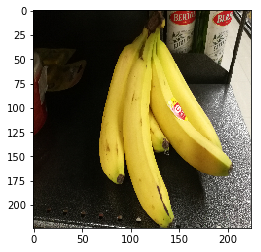

In [0]:

model.load_weights(weightsfile)
print("weights Loaded")
# %% Block 6a: Predictions on Test Image (With labels)

y_pred = []
test_shape = []
prediction = []
total_loss = 0

for i in range(len(test_imgs)):
    # for i in range(2):

    # Getting Ground Truth Y Label
    filename = test_imgs[i].split('\\')[-1]

    image_aug, y_truth = image_augmentation(filename, img_dir=test_image_dir, data_csv=data_csv)
    y_truth = y_truth.reshape(1, y_truth.shape[0], y_truth.shape[1])
    y_truth = label_encoder(y_truth)

    # Getting Predicted Y
    img = cv2.imread(test_imgs[i])
    img_shape = [img.shape[0], img.shape[1]]
    test_shape.append(img_shape)

    img = cv2.resize(img, (224, 224))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
    if diagnose:
      Current_pred = y_truth
    else:
      Current_pred = model.predict(img)
      
    prediction.append(Current_pred)
    y_pred_decoded = decode_detections(Current_pred,
                                       confidence_thresh=confidence_thresh,
                                       iou_threshold=iou_threshold,
                                       top_k=200)
    y_pred.append(y_pred_decoded)

    # Computing Loss
    total_loss = tf.add(ssd_loss.compute_loss(y_truth, Current_pred), total_loss)

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    print('The total loss for the entire test set is %.2f' % total_loss.eval())


# Converting Prediction to actual Image Size
for i in range(len(y_pred)):# for each image
    for j in range(len(y_pred[i][0])): # for each bounding box
        # x axis with img rows
        y_pred[i][0][j][2] = y_pred[i][0][j][2] / img_width * test_shape[i][1]
        y_pred[i][0][j][4] = y_pred[i][0][j][4] / img_width * test_shape[i][1]

        # y axis with img cols
        y_pred[i][0][j][3] = y_pred[i][0][j][3] / img_height * test_shape[i][0]
        y_pred[i][0][j][5] = y_pred[i][0][j][5] / img_height * test_shape[i][0]



## 6.2 Plotting Prediction

Selected Image shape: (2976, 3968, 3)
coordinates when plotting 1103.9217769077848 325.69339861188615 2966.602530343192 2565.8621586390905


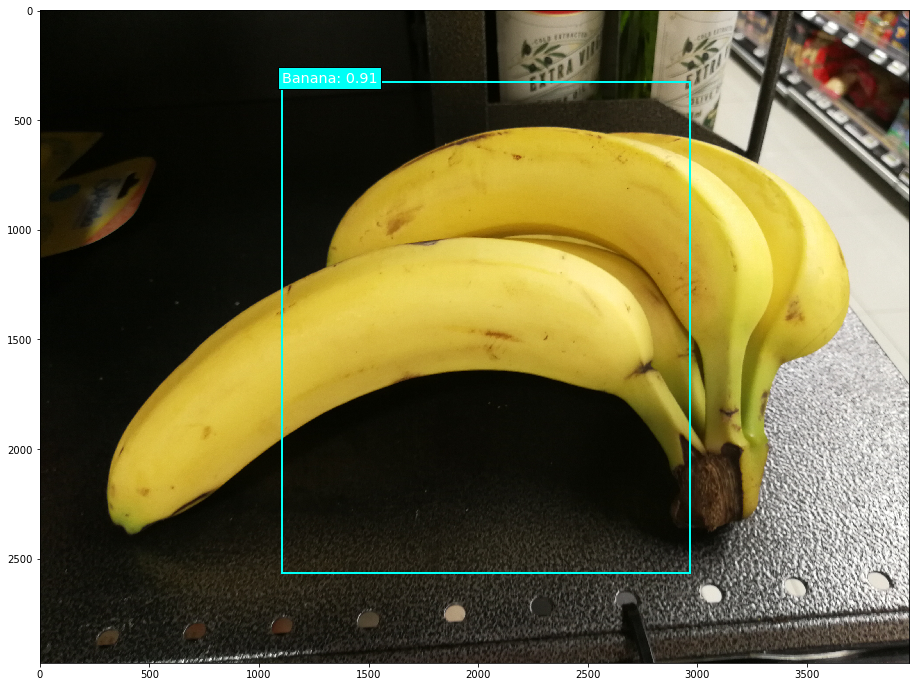

end


In [0]:

colors = plt.cm.hsv(np.linspace(0, 1, n_classes + 1)).tolist()  # colors for the bounding boxes
classes = ['background','Banana', 'Apple']
select_idx =7# select the test image to display
img = cv2.imread(test_imgs[select_idx])
plt.figure(figsize=(20, 12))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

current_axis = plt.gca()

print('Selected Image shape:', img.shape)

for box in y_pred[select_idx][0]:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    print('coordinates when plotting',xmin, ymin, xmax, ymax)
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, color=color, fill=False, linewidth=2))
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor': color, 'alpha': 1.0})

plt.show()
print('end')
